Like many young adults our age, when Covid hit my partner and I quickly fled the city and went to move in with his parents in rural New Hampshire. Turns out I actually really enjoy living in rural New Hampshire, and so in December we officially moved in to our own place in southern NH.

While we work from home the majority of the time, there are still some days here and there where we drive in to Boston. One thing I've noticed since living here is that there seems to be a time warp during Boston morning traffic, where it seems physically impossible to arrive in Boston between a certain time period. And that time period happens to be around when you'd usually want to get in, roughly when work starts in the morning.

After finding myself puzzling over the optimal time to leave to get to Boston early but without spending too much unnecessary extra time in the car, I decided to look into it - with data!

I was hoping that there would be a google maps API or something I could use to programmatically generate a bunch of travel time estimates for the route between my house and Central Square, where I work. Unfortunately, it turns out that (1) the google maps API isn't free (though there is a "free tier" up to a certain number of queries) and (2) using it to grab data without showing an accompanying map violates the API [terms of service](https://cloud.google.com/maps-platform/terms/) (section 3.2.3).

So instead, I just manually "generated" the data by inputting my destination and modifying the departure date and time. I collected data on the two primary routes I can take, one via I-93 S and the other via route 3, and covered times between 5 am and 9:30 am, which matches my intuition for when the Boston traffic time warp is. Because this was very manual data collection, I only did this for 5 days, ffrom 9/12 to 9/16. For each date and time of departure, I tracked the google maps estimate of the shortest & longest duration, as well as what color those estimates were (like when the google maps estimate is red and you know you're in for miserable traffic, that would be "red").

The data I gathered looked like this:

In [74]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

from datetime import timedelta

In [75]:
df = pd.read_csv('Commute - NH - Boston.csv')
df.head()

,date,depart_time,travel_time_min,travel_time_max,color,route
0,2022-09-12,5:00 AM,1h25,1h50,green,route 3
1,2022-09-12,5:00 AM,1h40,2h10,green,93
2,2022-09-13,5:00 AM,1h40,2h20,green,93
3,2022-09-13,5:00 AM,1h30,2h20,green,route 3
4,2022-09-14,5:00 AM,1h30,2h,green,route 3


Without even doing any data analysis, the first thing that struck me was that the estimates all seemed quite low. From personal anecdotal experience these maximum travel times feel more like optimistic estimates - it often takes 30-45 min longer than the initial expected arrival time, sometimes up to 60 min longer. The minimum time feels right - without any traffic, it's about an hour and half. But even just yesterday I drove into Boston and found myself stuck at Boston's worst intersection (getting off I-90 east to get into Cambridge, that stressful left exit going into the terrible confusing traffic light intersection across the bridge. Yes, I used to live right by that intersection for many years so I should have known better, but alas) - traffic which added at least 20 minutes to my commute, all at the very end of it.

The coloring also feels quite off, with the vast majority being green or orange annd only a couple of commutes in the red. I would have expected many more of these time periods to be "red". But maybe that's reserved only for when Google knows that there's _currently_ an accident or other blockage? Because every single day I've driven in to Boston, the time estimate has turned red for at least part of my trip (if not the entire last third).

Anyway, let's see what the data says! First, I have to do some wrangling to get all the dates and times processed in a way that will be amenable to plotting:

In [76]:
# Convert travel times to minutes
def convert_to_minutes(s):
    s = s.split('h')
    mins = float(s[0])*60
    if s[1]:
        mins += float(s[1])
    return mins

df['travel_time_min_minutes'] = df['travel_time_min'].apply(lambda x: convert_to_minutes(x))
df['travel_time_max_minutes'] = df['travel_time_max'].apply(lambda x: convert_to_minutes(x))

# Calculate estimated arrivals
df['depart_datetime'] = pd.to_datetime(df['date'] + ' ' + df['depart_time'])
df['arrival_time_min'] = df.apply(
    lambda row: row['depart_datetime'] + timedelta(minutes=row['travel_time_min_minutes']), 
    axis=1
)
df['arrival_time_max'] = df.apply(
    lambda row: row['depart_datetime'] + timedelta(minutes=row['travel_time_max_minutes']), 
    axis=1
)

# Give times a dummy date, since I want to just compare times regardless of day of the week
df['depart_datetime_nodate'] = df['depart_datetime'].apply(lambda d: d.replace(year=2022, month=9, day=8))
df['arrival_time_max_nodate'] = df['arrival_time_max'].apply(lambda d: d.replace(year=2022, month=9, day=8))

Let's start with the simplest possible thing - what's the relationship between the time I leave and the duration of the trip?

Text(0, 0.5, 'Max total travel time (minutes)')

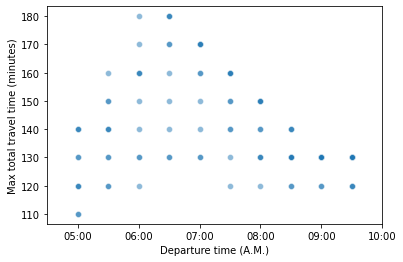

In [123]:
ax = sns.scatterplot(data=df, x='depart_datetime_nodate', y='travel_time_max_minutes', alpha=0.5)
ax.set_xlim([pd.to_datetime('2022-09-08 04:30:00'), pd.to_datetime('2022-09-08 10:00:00')])

ax.set_xlabel('Departure time (A.M.)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.set_ylabel('Max total travel time (minutes)')

Ok, so annywhere from two to three hours - that checks out. Already here you can see one of the key points of this whole thing: the range of possible durations for the same departure time is huge! More on that later.

Next up, let's see which route seems to be faster:

Text(0, 0.5, 'I-93 S travel time (min)')

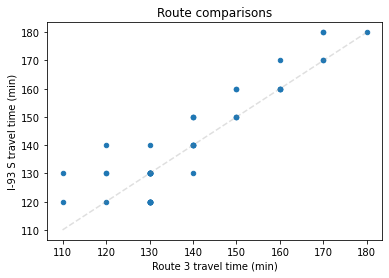

In [125]:
route_df = df.pivot(
    index='depart_datetime', columns='route', values='travel_time_max_minutes'
)

fig, ax = plt.subplots()
ax.plot([110, 180], [110, 180], color='gray', linestyle='--', alpha=0.25)
ax = route_df.plot(kind='scatter', x='route 3', y='93', ax=ax)

ax.set_title('Route comparisons')
ax.set_xlabel('Route 3 travel time (min)')
ax.set_ylabel('I-93 S travel time (min)')

Interesting, this data seems to indicate that the routes are roughly equivalent but the I-93 route often takes longer than going on Route 3. While I see how a computer would think this, as a human it really doesn't check out.

What I think might be going on here is that 93 has a more predictable amount of traffic than Route 3, and so its estimates are taking into account that traffic while the Route 3 estimates aren't able to. It would make sense for Google's algorithm to incorporate its confidence in the amount & location of traffic when it gives you estimates for travel in the future. As a computer, the data is very clear: 93 south has remarkable traffic in the same spots every single day. It's easy to measure and very consistent, and therefore very very predictable. Route 3, on the other hand, _theoretically_ should have less traffic because it's _not_ the main thoroughfare into Boston - the route goes through Nashua and then veers west to go around Boston before taking 90 East back into Cambridge. Of course, though, there's always traffic or accidents on this route - it's just that maybe the traffic isn't always in the exact same spot and so the algorithm isn't conffident enough in it to incorporate it in its predictions. (Though if you ask me, the clusterf\*ck of that intersection I found myself stuck in yesterday absolutely _is_ predictable and should have been incorporated into the algorithm by now! Come on neural nets, get it together!)

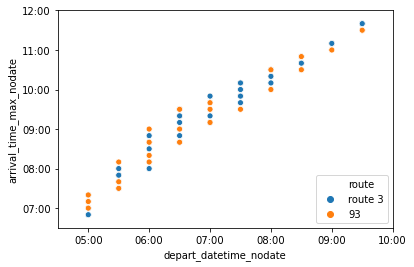

In [81]:
ax = sns.scatterplot(
    data=df, x='depart_datetime_nodate', y='arrival_time_max_nodate',
    hue='route'
)

ax.set_xlim([pd.to_datetime('2022-09-08 04:30:00'), pd.to_datetime('2022-09-08 10:00:00')])
ax.set_ylim([pd.to_datetime('2022-09-08 06:30:00'), pd.to_datetime('2022-09-08 12:00:00')])
ax.legend(loc='lower right')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

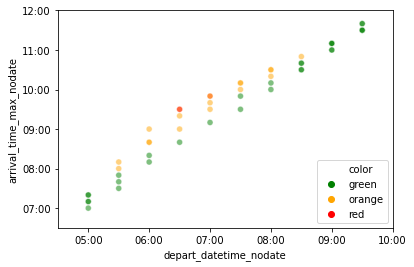

In [98]:
ax = sns.scatterplot(
    data=df.query('route == "93"'), x='depart_datetime_nodate', y='arrival_time_max_nodate',
    hue='color', alpha=0.5,
    palette={'red': 'red', 'green': 'green', 'orange': 'orange'}
)

ax.set_xlim([pd.to_datetime('2022-09-08 04:30:00'), pd.to_datetime('2022-09-08 10:00:00')])
ax.set_ylim([pd.to_datetime('2022-09-08 06:30:00'), pd.to_datetime('2022-09-08 12:00:00')])
ax.legend(loc='lower right')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

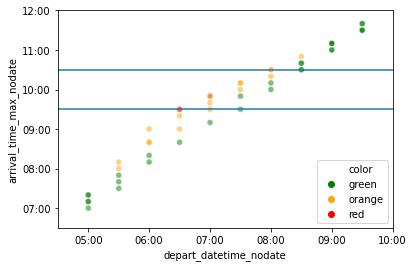

In [103]:
ax = sns.scatterplot(
    data=df.query('route == "93"'), x='depart_datetime_nodate', y='arrival_time_max_nodate',
    hue='color', alpha=0.5,
    palette={'red': 'red', 'green': 'green', 'orange': 'orange'}
)

ax.set_xlim([pd.to_datetime('2022-09-08 04:30:00'), pd.to_datetime('2022-09-08 10:00:00')])
ax.set_ylim([pd.to_datetime('2022-09-08 06:30:00'), pd.to_datetime('2022-09-08 12:00:00')])
ax.legend(loc='lower right')

ax.axhline(y=pd.to_datetime('2022-09-08 09:30:00'))
ax.axhline(y=pd.to_datetime('2022-09-08 10:30:00'))


ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

In [101]:
# Difference in max travel time between days
df.groupby('depart_time')['travel_time_max_minutes'].max() - df.groupby('depart_time')['travel_time_max_minutes'].min()


depart_time
5:00 AM    30.0
5:30 AM    40.0
6:00 AM    60.0
6:30 AM    50.0
7:00 AM    40.0
7:30 AM    40.0
8:00 AM    30.0
8:30 AM    20.0
9:00 AM    10.0
9:30 AM    10.0
Name: travel_time_max_minutes, dtype: float64


# Data collection

Manual

Estimates all seem quite low, from personal anecdotal experience these maximum travel times feel more like optimistic estimates - it often takes 30-45 min longer than the initial expected arrival time, sometimes up to 60 min longer.

So does the coloring - I would have expected many more of these time periods to be "red". Maybe that's reserved only for when Google knows that there's _currently_ an accident or other blockage?

# Results

Commuting between 5:30 am and 8:30 am puts you in the Boston traffic time warp: a period of  unpredictable and highly variable traffic, when leaving on a bad day gets you to Boston at the same time as leaving a full hour later but on a good day.

Outside of this time period, travel time to Boston is quite stable at around max two hours. But within the time period, the max travel time to Boston can get up to 3 hours depending on the day of the week. And that's not even counting accidents, road work, or whatever else doesn't go into Google's prediction algorithm! 

# Conclusion

To make the best use of my time, I should really try to leave home at 9. Usually though I end up leaving around 8 - this is sort of the balance point for me where I'm comfortable gambling on it being a good day (and thus getting to Boston early enough to enjoy a leisurely coffee), but not so early that if I get stuck in traffic I'll be very annoyed at all the time I wasted. Also, two and half hours doesn't feel too too bad for a commute in, but only because I don't do it very often. From this analysis, though, it does seem like leaving at 8:30 am is probably a better bet - I don'nt get to Boston that much later, but the day-to-day variability in my commute will be lower, thus leading to hopefully less frustration.

Anyway, I already mostly knew this - scheduling anything in Boston before 11 am is a gamble unless I'm willing to leave super early. I didn't really realize just how early I'd need to leave - I would have guess 6 am was fine but no, it's 5 am or bust.

Another thinng I did learn is just how unreliable google maps estimates are during periods of traffic!


- Range of times outside of these hours is so much tighter
- Difference between good days and bad days can be up to an hour (so unhelpful for planning!)
- If you want to miss traffic (no orange dots), leave before 5 am or after 9 am (meanning you have to arrive after 10:30 at the earliest)


tl'dr - leaving between 5:30 and 9 am means your commute is unpredictable and will likely suck

which means that getting into Boston between 7:30 am and 10:30 am sucks.

leaving at 7:30 am on a bad day means you arrive at the same time as leaving at 8:30 on a good day :sob:


Future work:
- ok, now do it but stop north of Medford